# 1. MDL with Degree-corrected SBM

## In Lecture 04, you learned about the Degree-Corrected Stochastic Block Model(DCSBM). In the practice session, you saw an example of inferring communities using maximum likelihood estimation with the DCSBM in a Jupyter Notebook. However, nto specifying the number of communities can lead to trivial community assignments, as seen in Exercise 013 and Lecture 05. In Lecture 05`s practice session, you learned about using the Minimum Description Length(MDL) principle to detect communities in a toy network with the standard Stochastic Block Model(SBM). Now, we will explore detecting communities in the Zachary Karate Club network using MDL with the DCSBM.

### (a) For the undirected DCSBM with N nodes and B blocks, while the MDL equation takes the familiar form:

$$\sum  = S + L$$

### where $\sum$ is the description length, S is the entropy of the DCSBM, and L is the information necessary to describe the model with its parameters, S and L are modified to account for the degree distribution of the network. S can be expressed:

$$S \thickapprox - E - \sum_{k} N_k \ln k! - \frac{1}{2} \sum_{rs} e_{rs} \ln \left( \frac{e_{rs}}{e_r e_s} \right)$$

### where $E = \frac{1}{2} \sum_{rs} e_{rs}$ s the total number of edges, $e_{rs}$ is the number of edges between blocks r and s, and $n_r$ are the number of nodes belonging to blocks r and s, respectively. $N_k$ is the total number of nodes with degree k, and the term - $\sum_{k} N_k \ln k!$ accounts for the degree distribution of the network. L can be expressed as

$$L \thickapprox E h \left( \frac{B(B + 1)}{2E} \right) + N \ln B - N \sum_{k} p_k \ln p_k$$

### where $h(x) = (1 + x) \ln (1 + x) - x \ln x$ and $p_k$ is the fraction of nodes with degree k. As you may have noticed, term - $N \sum_{k} p_k \ln p_k$ modifies L o account for the degree distribution. Use this MDL equation to partition the Karate Club network into communities. The network can be obtained via Netzschleuder under the name karate. Plot the communities and the degree distributions of the nodes in each community. Compare these communities to communities inferred using MDL with the standard SBM.

In [1]:
import math
import queue
from typing import Callable
from collections import Counter

import numpy as np
import scipy as sp
import pathpy as pp
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
karate_network = pp.io.graphtool.read_netzschleuder_network('karate', '77')
karate_network.plot(edge_color="grey")

In [3]:
def color_graph_communities(network: pp.Network, z_detected):
    number_of_blocks = len(set(z_detected))
    colors = sns.color_palette("Set1", number_of_blocks)
    for node in network.nodes:
        community = z_detected[network.nodes.index[node.uid]]
        node['color'] = colors[community]

In [4]:
def remap_communities(z):
    z_new = np.zeros(len(z), dtype=int)
    j = 0
    mapping = {}
    for i in range(len(z)):
        if z[i] not in mapping:
            mapping[z[i]] = j
            j += 1
    for i in range(len(z)):
        z_new[i] = mapping[z[i]]
    return z_new

In [5]:
real_groups = [node["groups"] for node in karate_network.nodes]
real_groups = remap_communities(real_groups)
real_groups

array([0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0])

In [6]:
color_graph_communities(karate_network, real_groups)
karate_network.plot(edge_color="grey")

In [7]:
def log2(x):
    if x == 0:
        return 0
    else:
        return np.log2(x)

In [8]:
def log(x):
    if x == 0:
        return 0
    else:
        return np.log(x)

In [9]:
def SBM_min_entropy(z, network: pp.Network):
    B = len(set(z))

    # C[k] counts number of nodes in block k
    C = Counter(z)

    H = 0
    
    # E[k,l] counts how many links exist between nodes in block k and block l
    E = np.zeros((B,B))

    # N[k,l] counts how many links can possibly exist between nodes in block k and l
    N = np.zeros((B,B))
    
    for k in range(B):
        for l in range(B):
            # calculate possible links
            if k == l:
                N[k,l] = sp.special.binom(C[k], 2)
            else:
                N[k,l]= C[k] * C[l]
            for e in network.edges:
                if (z[network.nodes.index[e.v.uid]] == k and z[network.nodes.index[e.w.uid]] == l) or (z[network.nodes.index[e.v.uid]] == l and z[network.nodes.index[e.w.uid]] == k):
                    E[k,l] += 1
    #print(C)
    #print(E)
    #print(N)
    for k in range(B):
        for l in range(k+1):
            H += np.log2(sp.special.binom(N[k,l], E[k,l]))
    return H

In [10]:
def Delta(z, network):
    B = len(set(z))
    m = network.number_of_edges()
    n = network.number_of_nodes()
    x = (B*(B+1))/(2*m)
    return m * ((1+x) * np.log(1+x) - x * np.log(x)) + n * np.log(B)

In [11]:
def description_length(z, network, min_entropy: Callable, delta: Callable,):
    return min_entropy(z, network) + delta(z, network)

In [12]:
def detect_communities_MDL(
        network: pp.Network,
        min_entropy: Callable,
        delta: Callable,
        iterations = 1000,
        cooling_slowness = 1,
):
    # initialization
    z = np.array(np.arange(network.number_of_nodes()))
    mdls = []
    for i in range(network.number_of_nodes()):
        z[i] = i
    l = description_length(z, network, min_entropy, delta)
    
    # we want to output the cooling temperatures to see the cooling schedule
    temperatures = []
    
    for i in tqdm(range(iterations)):
        # the temperature:
        t = (1+cooling_slowness)/(i+1+cooling_slowness)
        temperatures.append(t)
        
        # randomly split/merge communities
        if max(z)>0:
            i,j = np.random.choice(max(z)+1, replace=False, size=2)
            z_new = z.copy()
            z_new[z_new == i] = j
            z_new = remap_communities(z_new)
            l_new = description_length(z_new, network, min_entropy, delta)
        else:
            x = np.random.choice(network.number_of_nodes(), replace=False, size=int(network.number_of_nodes()/2))
            z_new = z.copy()
            z_new[x] = 1
            z_new = remap_communities(z_new)

        if l_new <= l or np.random.random() <= np.exp(-(l_new-l)/t):
            z = z_new
            l = l_new
        mdls.append(l)
    return z, mdls, temperatures

First of all let`s find blocks by MLD with the standard SBM.

In [13]:
z_mdl, _, _ = detect_communities_MDL(karate_network, SBM_min_entropy, Delta, iterations=200, cooling_slowness=10)
z_mdl

100%|██████████| 200/200 [01:01<00:00,  3.26it/s]


array([0, 1, 2, 3, 1, 3, 2, 1, 2, 1, 2, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2, 0,
       1, 3, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2])

In [14]:
color_graph_communities(karate_network, z_mdl)
karate_network.plot(edge_color="grey")

Here is the degree distributions by communities.

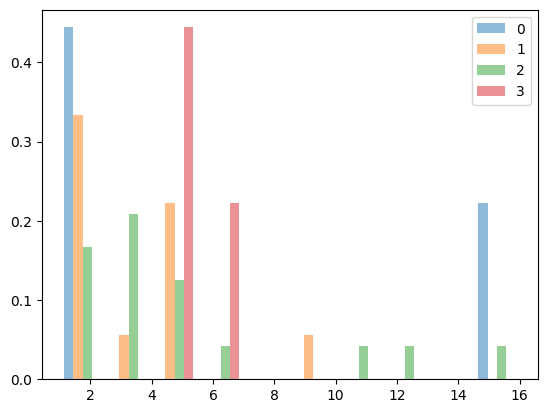

In [15]:
degrees = np.array([i[1] for i in sorted(karate_network.degrees().items(), key=lambda x: int(x[0]))])

data = [degrees[z_mdl == block] for block in np.unique(z_mdl)]
plt.hist(data, alpha=0.5, label=np.unique(z_mdl), histtype="bar", density=True)
plt.legend()
plt.show()

Let`s code the DCSBM entropy and describing information.

Formula:
$$S \thickapprox - E - \sum_{k} N_k \ln k! - \frac{1}{2} \sum_{rs} e_{rs} \ln \left( \frac{e_{rs}}{e_r e_s} \right)$$

The first term consists of number of links in the whole network:
$$-E$$

The second term accounts for the degree distribution:
$$- \sum_{k} N_k \ln k!$$

The third term:
$$- \frac{1}{2} \sum_{rs} e_{rs} \ln \left( \frac{e_{rs}}{e_r e_s} \right)$$

In [16]:
def DCSBM_min_entropy(z, network: pp.Network):

    E = network.number_of_edges()
    first_term = -1 * E

    second_term = 0
    degrees = np.array([i[1] for i in sorted(karate_network.degrees().items(), key=lambda x: int(x[0]))])
    for each_degree in np.unique(degrees):
        second_term -= np.sum(degrees == each_degree) * log(math.factorial(each_degree))

    third_term = 0
    for k in np.unique(z):
        for l in np.unique(z):
            e_kl = 0
            for e in network.edges:
                if (z[network.nodes.index[e.v.uid]] == k and z[network.nodes.index[e.w.uid]] == l) or (z[network.nodes.index[e.v.uid]] == l and z[network.nodes.index[e.w.uid]] == k):
                    e_kl += 1
            e_k = np.sum(degrees[z == k])
            e_l = np.sum(degrees[z == l])
            third_term -= 1/2 * e_kl * log(e_kl / (e_k * e_l))

    return first_term + second_term + third_term

In [17]:
def dc_delta(z, network):
    degrees = np.array([i[1] for i in sorted(karate_network.degrees().items(), key=lambda x: int(x[0]))])

    B = len(set(z))
    m = network.number_of_edges()
    n = network.number_of_nodes()
    x = (B*(B+1))/(2*m)

    third_term = 0
    for each_degree in degrees:
        p_k = np.sum(degrees == each_degree) / len(degrees)
        third_term -= p_k * log(p_k)
    return m * ((1+x) * np.log(1+x) - x * np.log(x)) + n * np.log(B) + n * third_term

In [18]:
z_dcsbm, _, _ = detect_communities_MDL(karate_network, DCSBM_min_entropy, dc_delta, iterations=200, cooling_slowness=10)
z_dcsbm

100%|██████████| 200/200 [00:29<00:00,  6.69it/s] 


array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1])

In [20]:
color_graph_communities(karate_network, z_dcsbm)
karate_network.plot(edge_color="grey")

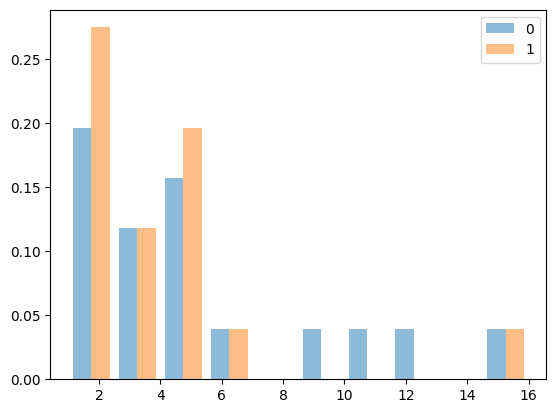

In [19]:
data = [degrees[z_dcsbm == block] for block in np.unique(z_dcsbm)]
plt.hist(data, alpha=0.5, label=np.unique(z_dcsbm), histtype="bar", density=True)
plt.legend()
plt.show()

So the network was devided into two communities and degrees in each community are quite different for the DCSSBM model. For the simple SBM model the degrees are pretty same.

### (b) The above approximate expression for the entropy SS only holds when
$$e_{rs} \frac{ \left< k^2 \right>_k - \left< k \right>_k }{\left< k \right>_k^2} \frac{ \left< k^2 \right>_r - \left< k \right>_r }{\left< k \right>_r^2} \ll n_k n_r$$

In [89]:
for k in np.unique(z_dcsbm):
    for l in np.unique(z_dcsbm):

        e_kl = 0
        for e in karate_network.edges:
            if (z_dcsbm[karate_network.nodes.index[e.v.uid]] == k and z_dcsbm[karate_network.nodes.index[e.w.uid]] == l) or (z_dcsbm[karate_network.nodes.index[e.v.uid]] == l and z_dcsbm[karate_network.nodes.index[e.w.uid]] == k):
                e_kl += 1

        k_block_degrees = degrees[z_dcsbm == k]
        mean_degree_k = np.mean(k_block_degrees)
        mean_degree_k_2 = np.mean(np.power(k_block_degrees, 2))
        mean_degree_k_squared = np.power(mean_degree_k, 2)
        n_k = np.sum(z_dcsbm == k)

        l_block_degrees = degrees[z_dcsbm == l]
        mean_degree_l = np.mean(l_block_degrees)
        mean_degree_l_2 = np.mean(np.power(l_block_degrees, 2))
        mean_degree_l_squared = np.power(mean_degree_l, 2)
        n_l = np.sum(z_dcsbm == l)

        if e_kl * ((mean_degree_k_2 - mean_degree_k)/mean_degree_k_squared) * ((mean_degree_l_2 - mean_degree_l)/mean_degree_l_squared) > n_k * n_l:
            raise ValueError("Sparsity does not work!")

print("Sparsity works!")

Sparsity works!


### (c) How is the entropy S related to the number of microstates of the DCSBM? What is the Probability P(G) of each microstate G?

The probability is
$$P(G) = \frac{1}{\Omega}$$
where $\Omega$ is the number of microstates.

The entropy S is:

$$S = \ln \Omega$$

The higher number of microstates the higher the entropy.

# 2. Kullback Leiber Divergence

## For two discrete probability mass functions Q and P defined on the same sample space Ω with events i, the Kullback-Leibler divergence (which is also called relative entropy) from Q to P is defined as:
$$D_{KL}(P||Q) := - \sum_{i Є  \Omega} P(i) * log\frac{Q(i)}{P(i)}$$

### (a) Consider a dice X with six faces and two different probability mass functions $$Q(X = 1) = \frac{1}{6}, Q(X = 2) = \frac{1}{6}, Q(X = 3) = \frac{1}{6}, Q(X = 4) = \frac{1}{6}, Q(X = 5) = \frac{1}{6}. Q(X = 6) = \frac{1}{6}$$ and $$Q(X = 1) = \frac{1}{3}, Q(X = 2) = \frac{1}{3}, Q(X = 3) = \frac{1}{12}, Q(X = 4) = \frac{1}{12}, Q(X = 5) = \frac{1}{12}. Q(X = 6) = \frac{1}{12}$$ Use python to compute two sequences of 1000 dice rolls with probabilities according to P and Q respectively. Use a binary Huffman code to encode the sequence and compute the number of bits required per symbol.

In [90]:
def generate_sequence(symbols, probs, n):
    return ''.join([x for x in np.random.choice(symbols, size=n, p=probs)])


def huffman_tree(sequence):

    huffman_tree = pp.Network()

    counts = Counter(sequence).most_common()
    seq_length = len(sequence)

    # symbols with lowest frequency have highest priority
    q = queue.PriorityQueue()
    for (symbol, count) in counts:
        # create leaf nodes and add to queue
        huffman_tree.add_node(symbol, color='orange', label='{0} / {1:.2f}'.format(symbol, count/seq_length))
        q.put((count, symbol))

    # Create huffman tree
    i = 0
    while q.qsize()>1:

        # retrieve two symbols with minimal frequency
        left = q.get()
        right = q.get()

        total_frequency = left[0] + right[0]

        # create internal node v with total frequency as label

        # prefix "n_" avoids ID conflicts if sequence to be encoded consists of numbers
        v = 'n_' + str(i)
        label = '{:.2f}'.format(total_frequency/seq_length)
        huffman_tree.add_node(v, label=label, color='gray')

        huffman_tree.add_edge(v, left[1], symbol='0', color='red')
        huffman_tree.add_edge(v, right[1], symbol='1', color='green')

        huffman_tree.nodes[v]['frequency'] = total_frequency

        q.put((left[0] + right[0], v))
        i += 1

    # generate the symbol to huffman code mapping
    root = q.get()
    return huffman_tree, root[1]


def generate_mapping(tree, node, prefix='', lookup_table={}):
    """Recursively turns Huffman tree into a lookup dictionary"""
    if tree.outdegrees()[node] == 0:
        lookup_table[tree.nodes[node].uid] = prefix
    else:
        for x in tree.successors[node]:
            generate_mapping(tree, x.uid, prefix=prefix + tree.edges[(node, x.uid)]['symbol'], lookup_table=lookup_table)

    return lookup_table


def calc_bit_per_symbol_for_prob(probable_symbols, probs, n):
    symbols_sequence = generate_sequence(probable_symbols, probs, n)
    haff_tree, root = huffman_tree(symbols_sequence)
    lookup_table = generate_mapping(haff_tree, root)
    compressed_symbols = ''.join([lookup_table[x] for x in symbols_sequence])
    return len(compressed_symbols) / n

In [91]:
dice_numbers = ["1", "2", "3", "4", "5", "6"]
dice_numbers

['1', '2', '3', '4', '5', '6']

In [92]:
q_probs = [1/6] * 6
q_bits_pear_symbol = calc_bit_per_symbol_for_prob(dice_numbers, q_probs, 1000)
print(f"The bits per symbol for Q(X) probability mass function {q_bits_pear_symbol}")

The bits per symbol for Q(X) probability mass function 2.641


In [93]:
p_probs = [1/3, 1/3, 1/12, 1/12, 1/12, 1/12]
p_bits_pear_symbol = calc_bit_per_symbol_for_prob(dice_numbers, p_probs, 1000)
print(f"The bits per symbol for Q(X) probability mass function {p_bits_pear_symbol}")

The bits per symbol for Q(X) probability mass function 2.246


As you see for the sequence where the more frequent symbols exist we can use less bits pear symbol for compressing the sequence.

### (b) Calculate the difference between the bits required for both sequences and compare it with the Kullback-Leibler divergence from Q to P . Interpret and explain your finding.

In [94]:
bits_pear_symbol_delta = np.abs(q_bits_pear_symbol - p_bits_pear_symbol)
print(f"The difference between the bits pear symbol is: {bits_pear_symbol_delta}")

The difference between the bits pear symbol is: 0.395


In [95]:
def log2(x):
    if x == 0:
        return 0
    else:
        return np.log2(x)


def relative_entropy(P, Q):
    relative_ent = 0
    for i in range(len(P)):
        relative_ent -= P[i] * log2(Q[i]/P[i])
    return relative_ent

In [96]:
rel_entrp = relative_entropy(p_probs, q_probs)
print(f"The Kullback-Leibler divergence is {rel_entrp}")

The Kullback-Leibler divergence is 0.3333333333333333


The Kullback-Leibler divergence can be interpreted as an average difference between the number of bits which we need to use to encode P and Q sequences with different probability mass functions.